# Решение классификации с помощью CatBoost

## Установка библиотек

In [1]:
#!pip install --user --upgrade catboost
#!pip install --user --upgrade ipywidgets
#!pip install shap
#!pip install sklearn
#!pip install --upgrade numpy
#!jupyter nbextension enable --py widgetsnbextension

In [106]:
import catboost
print(catboost.__version__)
!python --version

1.0.3
Python 3.8.10


## Чтение данных

In [107]:
import pandas as pd
import os
import numpy as np
np.set_printoptions(precision=4)
import catboost
from catboost import *
from catboost import datasets
from sklearn.metrics import classification_report,plot_confusion_matrix
import matplotlib.pyplot as plt 

In [108]:
#filepath
file_path= "telco-customer-churn.csv"

In [109]:
df=pd.read_csv(file_path)
df.head()

,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,homeowner,...,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,totalcallduration,avgcallduration,churn,year,month
0,12,168147,0.06,0.00,4251078442,1,Yes,Bachelor or equivalent,Male,Yes,...,15,19,No,No,0.82,5971,663,0,2015,1
1,12,168147,0.06,0.00,4251078442,1,Yes,Bachelor or equivalent,Male,Yes,...,15,19,No,No,0.82,3981,995,0,2015,2
2,42,29047,0.05,0.01,4251043419,2,Yes,Bachelor or equivalent,Female,Yes,...,212,34,No,Yes,0.27,7379,737,0,2015,1
3,42,29047,0.05,0.01,4251043419,2,Yes,Bachelor or equivalent,Female,Yes,...,212,34,No,Yes,0.27,1729,432,0,2015,2
4,58,27076,0.07,0.02,4251055773,3,Yes,Master or equivalent,Female,Yes,...,216,144,No,No,0.48,3122,624,0,2015,1


## Подготовка данных

Извлечение значений меток

In [110]:
y = df.churn
X = df.drop(['churn', 'year', 'month', 'noadditionallines'], axis=1)

Декларация категориальных признаков

In [111]:
cat_features = list(X.select_dtypes(include=['object']).columns.values.tolist())
cat_features

['customersuspended',
 'education',
 'gender',
 'homeowner',
 'maritalstatus',
 'occupation',
 'state',
 'usesinternetservice',
 'usesvoiceservice']

Просмотр баланса меток в наборе данных

In [112]:
print('Labels: {}'.format(set(y)))
print('Zero count = {}, One count = {}'.format(len(y) - sum(y), sum(y)))

Labels: {0, 1}
Zero count = 18605, One count = 1863


Создание класса Pool

In [113]:
pool = Pool(data=X, label=y, cat_features=cat_features)

print('Dataset shape:' + str(pool.shape))
print('\n')
print('Column names dataset:')
print(pool.get_feature_names()) 

Dataset shape:(20468, 25)


Column names dataset:
['age', 'annualincome', 'calldroprate', 'callfailurerate', 'callingnum', 'customerid', 'customersuspended', 'education', 'gender', 'homeowner', 'maritalstatus', 'monthlybilledamount', 'numberofcomplaints', 'numberofmonthunpaid', 'numdayscontractequipmentplanexpiring', 'occupation', 'penaltytoswitch', 'state', 'totalminsusedinlastmonth', 'unpaidbalance', 'usesinternetservice', 'usesvoiceservice', 'percentagecalloutsidenetwork', 'totalcallduration', 'avgcallduration']


## Разделение данных на train и validation¶

In [114]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=1234)

## Постоение и сравнение моделей

In [116]:
model1 = CatBoostClassifier(
    iterations=2000,
    random_seed=63,
    learning_rate=0.1,
    custom_loss=['AUC', 'Accuracy'],
    early_stopping_rounds=50,
    train_dir='learing_rate_0.1'
)

model2 = CatBoostClassifier(
    iterations=2000,
    random_seed=63,
    learning_rate=0.2,
    custom_loss=['AUC', 'Accuracy'],
    early_stopping_rounds=50,
    train_dir='learing_rate_0.2'
)

model3 = CatBoostClassifier(
    iterations=2000,
    random_seed=63,
    learning_rate=0.3,
    custom_loss=['AUC', 'Accuracy'],
    early_stopping_rounds=50,
    train_dir='learing_rate_0.3'
)

model1.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)
model2.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)

model3.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)

In [117]:
from catboost import MetricVisualizer
MetricVisualizer(['learing_rate_0.1', 'learing_rate_0.2', 'learing_rate_0.3']).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

KeyboardInterrupt: 

## Кросс-валидация

In [118]:
from catboost import cv_data

params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 2000
params['custom_loss'] = 'AUC'
params['random_seed'] = 63
params['learning_rate'] = 0.3

cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    type = 'Classical',
    early_stopping_rounds=50,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=True,
    verbose=False
)

best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.08138733437
bestIteration = 812

Training on fold [1/5]

bestTest = 0.09347375534
bestIteration = 661

Training on fold [2/5]

bestTest = 0.08102111275
bestIteration = 613

Training on fold [3/5]

bestTest = 0.07546217741
bestIteration = 837

Training on fold [4/5]

bestTest = 0.07657680661
bestIteration = 826

Best validation Logloss score, stratified: 0.0820±0.0074 on step 813


## Тюнинг модели

In [119]:
tunned_model = CatBoostClassifier(
    custom_loss=['AUC','Recall'],
    iterations=2000,
    random_seed=63,
    learning_rate=0.275,
    l2_leaf_reg=2.5,
    bagging_temperature=1,
    random_strength=1,
    one_hot_max_size=2,
    early_stopping_rounds=100,
    leaf_estimation_method='Newton'
)
tunned_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Просмотр количества деревьев

In [79]:
print(tunned_model.tree_count_)

834


Матрица ошибок

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


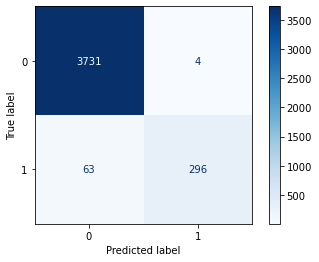

In [121]:
plot_confusion_matrix(tunned_model,X_validation,y_validation,cmap=plt.cm.Blues)

## Выбор границы принятия решения (исходя из бизнес аналитики)

Поиск границ для наилучших показателей FPR, FNR

In [122]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

eval_pool = Pool(X_validation, y_validation, cat_features=cat_features)
curve = get_roc_curve(tunned_model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

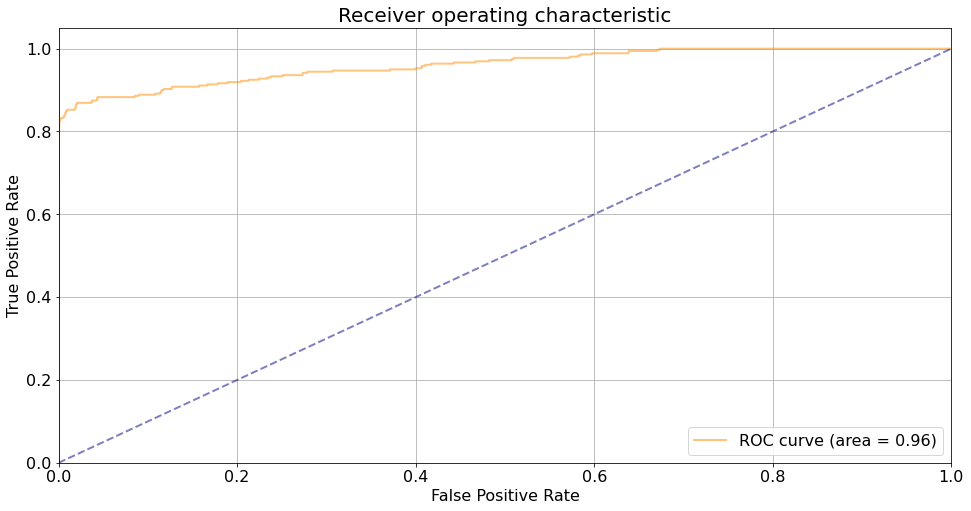

In [123]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [124]:
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

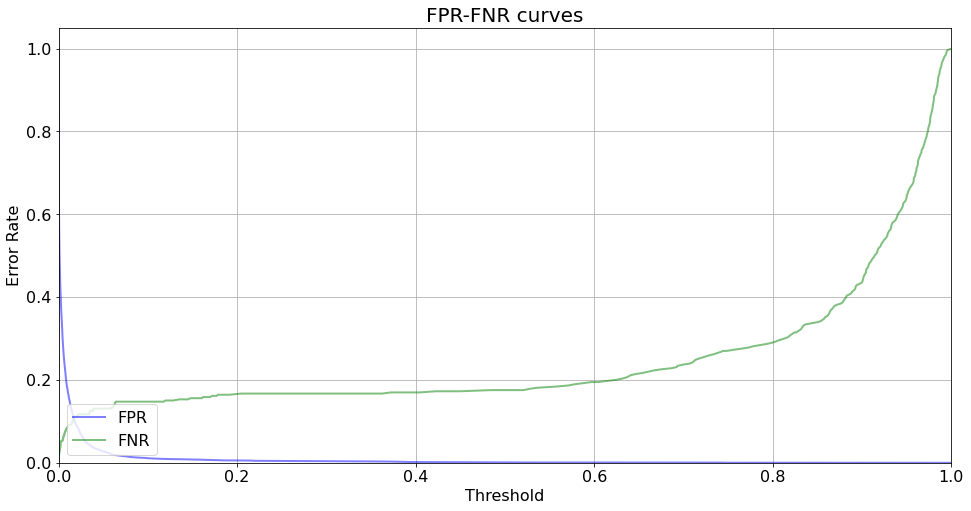

In [125]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()

In [126]:
from catboost.utils import select_threshold

print(select_threshold(model=tunned_model, data=eval_pool, FNR=0.18))
print(select_threshold(model=tunned_model, data=eval_pool, FPR=0.18))

0.5268838615520032
0.009759896829338467


## Model predictions

In [87]:
print(tunned_model.predict_proba(X=X_validation))

[[1.0000e+00 2.2807e-06]
 [9.9938e-01 6.2389e-04]
 [9.5971e-01 4.0289e-02]
 ...
 [3.9019e-02 9.6098e-01]
 [1.7941e-02 9.8206e-01]
 [9.9973e-01 2.7392e-04]]


In [90]:
print(tunned_model.predict(data=X_validation))

[0 0 0 ... 1 1 0]


In [92]:
raw_pred = tunned_model.predict(
    data=X_validation,
    prediction_type='RawFormulaVal'
)
print(raw_pred)

[-12.991   -7.3789  -3.1705 ...   3.2039   4.0025  -8.2024]


In [93]:
from numpy import exp

sigmoid = lambda x: 1 / (1 + exp(-x))

probabilities = sigmoid(raw_pred)

print(probabilities)

[2.2807e-06 6.2389e-04 4.0289e-02 ... 9.6098e-01 9.8206e-01 2.7392e-04]



## Важность фичей

In [127]:
tunned_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,age,15.787603
1,unpaidbalance,11.279861
2,numberofcomplaints,9.172337
3,percentagecalloutsidenetwork,6.731039
4,monthlybilledamount,6.132847
5,numdayscontractequipmentplanexpiring,6.012654
6,callingnum,6.011997
7,totalminsusedinlastmonth,5.801265
8,customerid,5.390384
9,penaltytoswitch,5.304387


## Shap values

In [128]:
shap_values = tunned_model.get_feature_importance(pool, type='ShapValues')
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
print(shap_values.shape)

(20468, 25)


Интерессная фича аналитики, как для отдельных строк, так и для срезов

In [130]:
import shap

shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], X.iloc[3,:])

In [131]:
import shap

shap.initjs()
shap.force_plot(expected_value, shap_values[91,:], X.iloc[91,:])

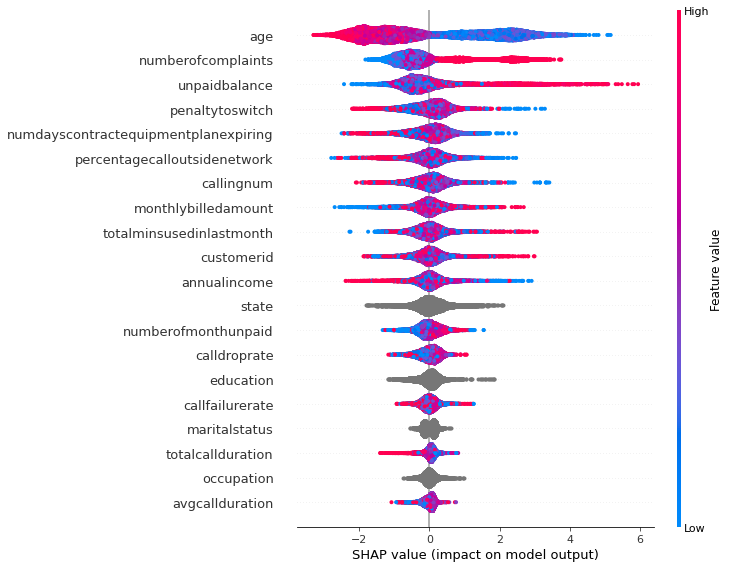

In [103]:
shap.summary_plot(shap_values, X)

In [104]:
X_small = X.iloc[0:200]
shap_small = shap_values[:200]
shap.force_plot(expected_value, shap_small, X_small)

 ## Сохранение модели в формате .json

In [132]:
tunned_model.save_model('catboost_model.json', format='json')

## Hyperparameter tunning

### Training speed

In [309]:
from catboost import CatBoost
fast_model = CatBoostClassifier(
    random_seed=63,
    iterations=150,
    learning_rate=0.01,
    boosting_type='Plain',
    bootstrap_type='Bernoulli',
    subsample=0.5,
    one_hot_max_size=20,
    rsm=0.5,
    leaf_estimation_iterations=5,
    max_ctr_complexity=1)

fast_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Training the model after parameter tunning

In [68]:
best_model = CatBoostClassifier(
    random_seed=63,
    iterations=int(tunned_model.tree_count_ * 1.2),
    custom_loss='AUC'
)
best_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=100
)

Learning rate set to 0.033261
0:	learn: 0.6597221	total: 53.3ms	remaining: 54.5s
100:	learn: 0.2590936	total: 2.83s	remaining: 25.9s
200:	learn: 0.2328454	total: 6.07s	remaining: 24.9s
300:	learn: 0.2131490	total: 9.55s	remaining: 22.9s
400:	learn: 0.1952478	total: 13s	remaining: 20.1s
500:	learn: 0.1788585	total: 16.4s	remaining: 17.2s
600:	learn: 0.1644219	total: 19.8s	remaining: 14s
700:	learn: 0.1508088	total: 23.1s	remaining: 10.6s
800:	learn: 0.1364694	total: 26.6s	remaining: 7.41s
900:	learn: 0.1250020	total: 30.3s	remaining: 4.13s
1000:	learn: 0.1154463	total: 34s	remaining: 782ms
1023:	learn: 0.1134979	total: 34.8s	remaining: 0us


C:\Users\Mi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


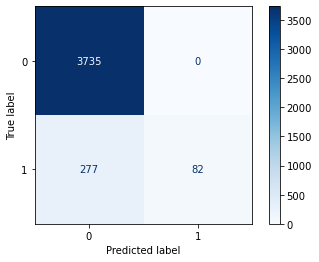

In [69]:
plot_confusion_matrix(best_model,X_validation,y_validation,cmap=plt.cm.Blues)

## Calculate predictions for the contest

In [358]:
test_pool = Pool(data=X_validation, cat_features=cat_features)
contest_predictions = best_model.predict_proba(test_pool)
print('Predictoins:')
print(contest_predictions)

Predictoins:
[[0.9791 0.0209]
 [0.5496 0.4504]
 [0.9245 0.0755]
 ...
 [0.9965 0.0035]
 [0.9174 0.0826]
 [0.9655 0.0345]]
